In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [39]:
df = pd.read_csv('../../../examples/EFIplus_medit.zip',compression='zip', sep=";")

In [40]:
# copying df setup from Ex9

df.drop(df.iloc[:,5:15], axis=1, inplace=True)
df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True)
df.columns = list(map(str, df.columns))

envi_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

filt_basins = (df['Catchment_name'] == 'Douro') | (df['Catchment_name'] == 'Tejo')
basins_df = df.loc[filt_basins, ['Catchment_name', *envi_vars]].dropna()
basins_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 1 to 4951
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Catchment_name        888 non-null    object 
 1   Altitude              888 non-null    int64  
 2   Actual_river_slope    888 non-null    float64
 3   Elevation_mean_catch  888 non-null    float64
 4   prec_ann_catch        888 non-null    float64
 5   temp_ann              888 non-null    float64
 6   temp_jan              888 non-null    float64
 7   temp_jul              888 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 62.4+ KB


1. Run a PCA based on quantitative environmental variables (see previous exercise), using sites from the
Douro and Tejo basins. Produce a biplot with ‘Catchment_name’ as a grouping variable

In [41]:
x = StandardScaler().fit_transform(basins_df[envi_vars])

pca = PCA(n_components=2)
PC = pca.fit_transform(x)

In [42]:
def biplot(score,coef,hue,labels=None): 
 
    xs = score[:,0] # PC1 object scores
    ys = score[:,1] # PC2 object scores 
    n = coef.shape[0] # number of dimensions (2)
    scalex = 1.0/(xs.max() - xs.min()) # to rescale scores
    scaley = 1.0/(ys.max() - ys.min()) # to rescale scores
    sns.scatterplot(x=xs * scalex,
                    y=ys * scaley,
                    hue=hue,
                    s=8, 
                    color='blue') # scatter plot using rescaled object scores
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'red',
                  head_width=0.01,
                  alpha = 0.5) # plot arrows for each variable
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'red', 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
 
    plt.figure()

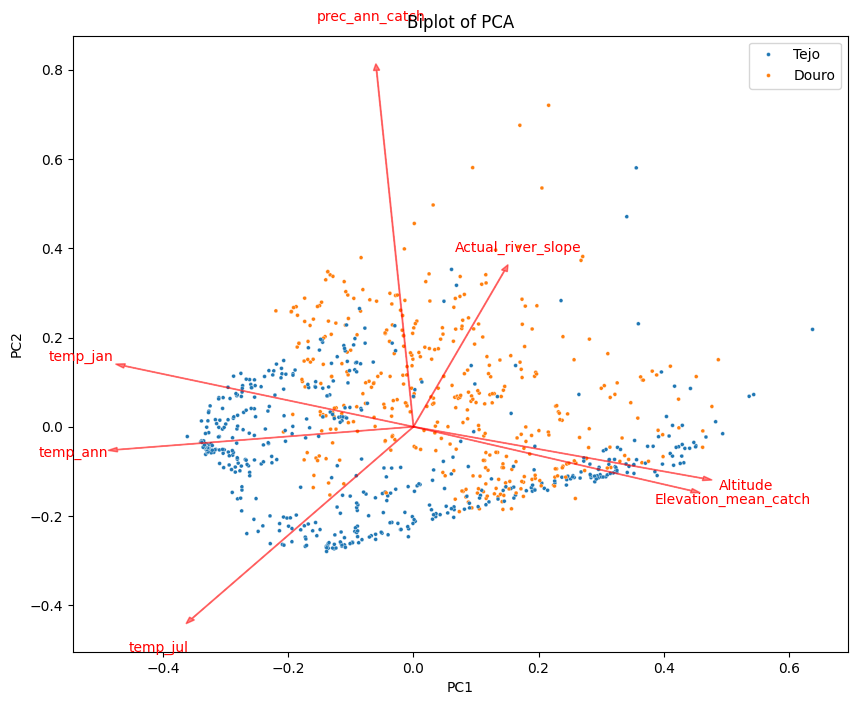

<Figure size 640x480 with 0 Axes>

In [43]:
plt.figure(figsize=(10, 8))
plt.title('Biplot of PCA')
 
biplot(PC, 
       np.transpose(pca.components_), 
       basins_df['Catchment_name'].tolist(),
       list(basins_df.columns[1:]))
plt.show()

2. Using the same data, run a PCoA and project the sites using the resulting first two axis. Use also the
‘Catchment_name’ as a grouping variable.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


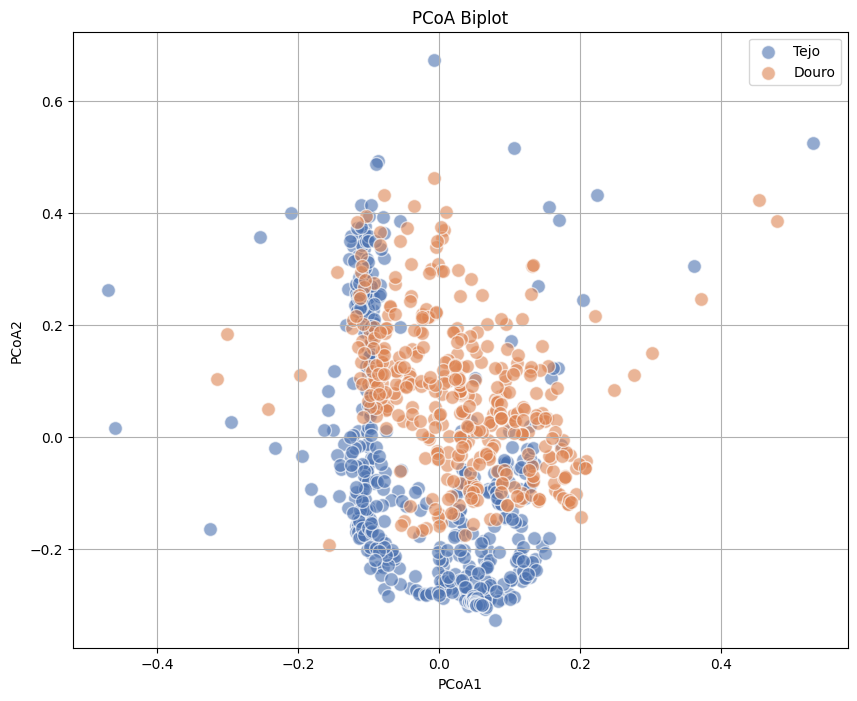

In [44]:
# Step 1: Standardize the data (excluding the 'Catchment_name' column)
x = basins_df[envi_vars].values
x = StandardScaler().fit_transform(x)

# Step 2: Compute the distance matrix
distance_matrix = pairwise_distances(x, metric='euclidean')

# Step 3: Perform PCoA using MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_results = mds.fit_transform(distance_matrix)

# Create a DataFrame with the PCoA results and the 'Catchment_name'
pcoa_df = pd.DataFrame(data=pcoa_results, columns=['PCoA1', 'PCoA2'])
final_df = pd.concat([pcoa_df, basins_df[['Catchment_name']]], axis=1)

def pcoa_biplot(score, catchment_names):
    xs = score[:, 0]  # PCoA1 scores
    ys = score[:, 1]  # PCoA2 scores
    scalex = 1.0 / (xs.max() - xs.min())  # to rescale scores
    scaley = 1.0 / (ys.max() - ys.min())  # to rescale scores

    unique_catchments = catchment_names.unique()
    colors = sns.color_palette('deep', len(unique_catchments))
    catchment_color_map = {catchment: colors[i] for i, catchment in enumerate(unique_catchments)}

    plt.figure(figsize=(10, 8))

    for catchment in unique_catchments:
        mask = catchment_names == catchment
        plt.scatter(xs[mask] * scalex, ys[mask] * scaley, s=100, color=catchment_color_map[catchment], label=catchment, alpha=0.6, edgecolor='w')

    plt.xlabel("PCoA1")
    plt.ylabel("PCoA2")
    plt.legend()
    plt.grid()
    plt.title('PCoA Biplot')
    plt.show()

# Step 4: Plot the PCoA biplot
pcoa_biplot(score=pcoa_results, catchment_names=basins_df['Catchment_name'])


3. Run a Linear Discriminant Analysis based on quantitative environmental variables (see previous
exercises), using the Douro and Tejo basins as the pre-determined groups. Produce a biplot with
‘Catchment_name’ as a grouping variable.

In [47]:
envi_df = basins_df[envi_vars]

In [50]:
X = envi_df
y = basins_df['Catchment_name'] 

# Fit the LDA model (we set to two components just for ilustration - default would be N_classes-1=5 in this case)
model = LDA(n_components=1)
DLA = model.fit_transform(X, y)

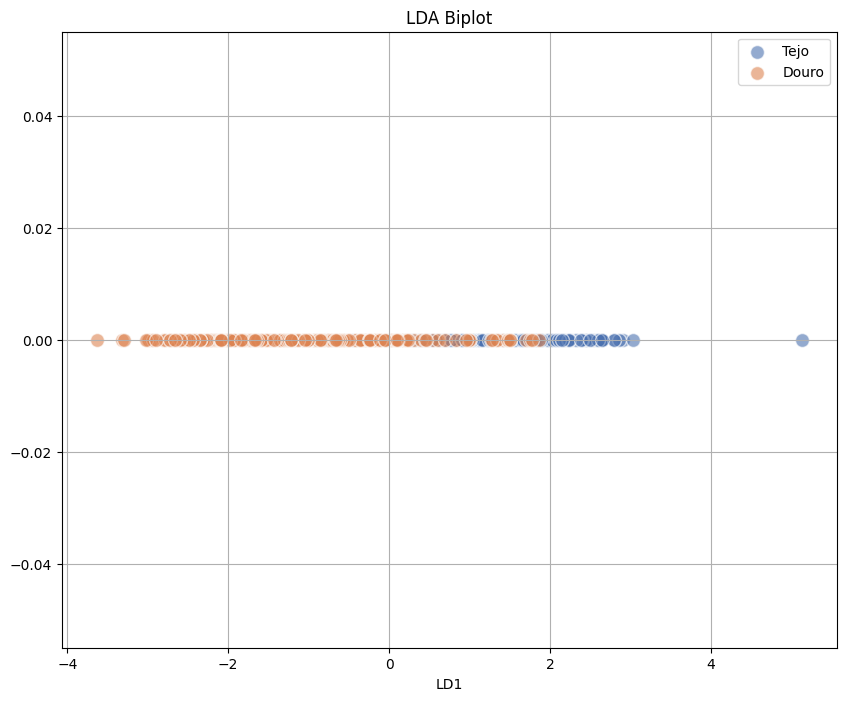

In [53]:
# Step 1: Standardize the data (excluding the 'Catchment_name' column)
x = basins_df[envi_vars].values
y = basins_df['Catchment_name'].values
x = StandardScaler().fit_transform(x)

# Determine the number of classes
n_classes = len(np.unique(y))

# Set the number of components for LDA
n_components = min(len(envi_vars), n_classes - 1)

# Step 2: Perform LDA
lda = LDA(n_components=n_components)
lda_components = lda.fit_transform(x, y)

# Create a DataFrame with the LDA results and the 'Catchment_name'
lda_df = pd.DataFrame(data=lda_components, columns=[f'LD{i+1}' for i in range(n_components)])
final_df = pd.concat([lda_df, basins_df[['Catchment_name']]], axis=1)

# Step 3: Plot the LDA results
def plot_lda_biplot(score, catchment_names):
    xs = score[:, 0]  # LD1 scores
    ys = score[:, 1] if score.shape[1] > 1 else np.zeros_like(xs)  # LD2 scores if available

    unique_catchments = catchment_names.unique()
    colors = sns.color_palette('deep', len(unique_catchments))
    catchment_color_map = {catchment: colors[i] for i, catchment in enumerate(unique_catchments)}

    plt.figure(figsize=(10, 8))

    for catchment in unique_catchments:
        mask = catchment_names == catchment
        plt.scatter(xs[mask], ys[mask], s=100, color=catchment_color_map[catchment], label=catchment, alpha=0.6, edgecolor='w')

    plt.xlabel("LD1")
    plt.ylabel("LD2" if score.shape[1] > 1 else "")
    plt.legend()
    plt.grid()
    plt.title('LDA Biplot')
    plt.show()

# Step 4: Plot the LDA biplot
plot_lda_biplot(score=lda_components, catchment_names=basins_df['Catchment_name'])
